In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from numpy import int64
from datetime import date, datetime

# Configuración

In [2]:
# La llave será el nombre final de la columna, el valor el nombre con el que se encuentra en los archivos brutos
COLUMNAS = {
    'DOCUMENTO': 'Número de Documento',
    'CODIGO': 'Codigo',
    'NOMBRE': 'Nombres',
    'APELLIDO': 'Apellidos',
    'TELEFONO': 'Teléfono Celular que usa',
    'EMAIL': 'Correo electrónico personal que usa',
    'DEDICACION RUTA': '¿Qué dedicación de tiempo diaria espera tener con el proyecto Misión TIC 2022?',
    'DISP_PROGRAMACION': 'Seleccione por lo menos dos (2) de las franjas horarias especificadas en las cuales tiene disponibilidad de tiempo para atender las clases sincrónicas del módulo de PROGRAMACIÓN que cursará durant...',
    'DISP_INGLES': 'Seleccione por lo menos dos (2) de las franjas horarias en las cuales tiene disponibilidad de tiempo para atender las clases sincrónicas del módulo INGLÉS (5 horas/semana), es decir (1 hora/día de...',
    'DISP_COACHING': 'Seleccione por lo menos dos (2) de las franjas horarias en las cuales tiene disponibilidad de tiempo para atender las clases sincrónicas del módulo COACHING/HABILIDADES PERSONALES (1 hora/semana)',
    'TRAB_COLABORATIVO': '¿Qué franja de horario le convendría para desarrollar el trabajo colaborativo que amerita el desarrollo de un proyecto Web o móvil? (Aplica para los Ciclos 3 y 4)',
    'FECHA_NACIMIENTO': 'Fecha de Nacimiento',
    'GENERO': 'Sexo',
    'NIVEL_EDUCATIVO_REAL': 'Nivel de Escolaridad',
    'OCUPACION': 'Ocupación',
    'TITULO_SI_TIENE': 'Si es técnico, tecnólogo o profesional, escriba su título académico',
    'DISCAPACIDAD': '¿Presenta alguna discapacidad?',
    'DETALLE_DISCAPACIDAD': "Si en la anterior pregunta su respuesta fue 'Si', por favor detalle el tipo de discapacidad.",
    'PAIS_NACIMIENTO':'País de Nacimiento',
    'CIUDAD_NACIMIENTO':'Ciudad de Nacimiento',
    'PAIS_DE_RECIDENCIA': 'País de Residencia',
    'CIUDAD_DE_RECIDENCIA': 'Ciudad de Residencia'
}

COLUMNAS_PSICOSOCIALES = {
    ''
}

COLUMNAS_ADICIONALES = {
    'nivelE': 'NIVEL_EDUCATIVO_AGRUPADO',
    'obs': 'OBSERVACION'
}

GRUPOS_EDUCATIVOS = {
    'BACHILLER': [
        'Ninguno',
        'Bachillerato Técnico',
        'Bachillerato Académico',
        'Bachillerato Comercial'
    ],
    'TÉCNICO': [
        'Técnica',
        'Tecnológico'
    ],
    'PROFESIONAL+': [
        'Posgrado',
        'Profesional'
    ]
}

GRUPOS_ETARIOS = {
    'No especifica': 0,
    'Errores': 0,
    '15 a 20': 0,
    '20 a 30': 0,
    '30 a 40': 0,
    '40 a 50': 0,
    '50 a 60': 0,
    'Más de 60': 0
}

JORNADA_DEFECTO_PROGRAMACION = 'Jornada de la noche (8 p.m. a 10 p.m.)'
JORNADA_DEFECTO_INGLES_COACH = 'Jornada de la noche (7 p.m. a 8 p.m.)'

In [3]:
ESTUDIANTES_EXCLUIDOS = [
    # Estudiantes que no entran a ciclo 1
    2220111, # Fabian David
    2220135, # Juan Diego
    2220249, # Farid Jose
    2220256, # Diego Alejandro
    2220605, # Miguel Ángel
    2220755, # Juan David
    2220841, # Gerson David
    2221039, # Hector Armando
    2221575, # Iván Camilo
    2222796, # Andrés Felipe
    2223097, # Camilo Andrés
    
    # Otros estudiantes debajo de esta línea
    # Estudiantes que no desean continuar
    2224295, # No está en el consolidado
    2224297, # No está en el consolidado
    2224300, # No está en el consolidado
    2224306, # No está en el consolidado
    2224320, # No está en el consolidado
    2224331, # No está en el consolidado
    2224336, # No está en el consolidado
    2224400, # No está en el consolidado
    2224425, # No está en el consolidado
    2224437, # No está en el consolidado
    2224450, # No está en el consolidado
    2224457, # No está en el consolidado
    2224464, # No está en el consolidado
    2224477, # No está en el consolidado
    2224579, # No está en el consolidado
    2224639, # No está en el consolidado
    2223233, 
    2224441, # No está en el consolidado
    2220474,
]

In [4]:
# FUNCIONES
def iniciarContadores(jornadas):
    dic = {}
    for jornada in jornadas:
        dic[jornada] = 0
    return dic
def tokenizadoFiltrado(cadena, separador, defecto):
    rta = []
    if (type(cadena) != str):
        return [defecto]
    tokens = cadena.split(separador)
    for token in tokens:
        if token != '':
            if token == 'Jornada de la tarde (10 a.m. a 11 a.m.)':
                rta.append('Jornada de la mañana (10 a.m. a 11 a.m.)')
            elif token == 'Jornada de la tarde (11 a.m. a 12 m.)':
                rta.append('Jornada de la mañana (11 a.m. a 12 m.)')
            else:
                rta.append(token)
    return rta
def calcularEdad(bdate):
    today = date.today()
    age = today.year - bdate.year - ((today.month, today.day) < (bdate.month, bdate.day))
    return age
def convertirFecha(fecha):
    if isinstance(fecha, pd._libs.tslibs.timestamps.Timestamp):
        return str(fecha)
    return str((pd.TimedeltaIndex([fecha], unit='d') + datetime(1899, 12, 30))[0])
def obtenerEdad(fecha):
    if fecha == '' or fecha == None:
        return -1
    if isinstance(fecha, pd._libs.tslibs.timestamps.Timestamp):
        return calcularEdad(fecha)    
    try:
        fecha = pd.TimedeltaIndex([fecha], unit='d') + datetime(1899, 12, 30)
        return calcularEdad(fecha)
    except:        
        return -2

# Procesamiento

In [5]:
archivos = glob.glob('./INPUT/INDAGAR/*.xlsx')
dfs = []
for archivo in archivos:
    dfs.append(pd.read_excel(archivo, engine = 'openpyxl'))
datos = pd.concat(dfs, ignore_index = True)
# Toma de las columnas valiosas
datos = datos[COLUMNAS.values()]

In [6]:
datos['Teléfono Celular que usa'] = datos['Teléfono Celular que usa'].astype(int64, errors='ignore')
datos['Teléfono Celular que usa'] = datos['Teléfono Celular que usa'].astype(str)

In [7]:
# Cargue de jornadas
JORNADAS = [
    'Jornada de la mañana (6 a.m. a 8 a.m.)',
    'Jornada de la mañana (8 a.m. a 10 a.m.)',
    'Jornada de la mañana (10 a.m. a 12 m.)',
    'Jornada de la tarde (12 m. a 2 p.m.)',
    'Jornada de la tarde (2 p.m. a 4 p.m.)',
    'Jornada de la tarde (4 p.m. a 6 p.m.)',
    'Jornada de la noche (6 p.m. a 8 p.m.)',
    'Jornada de la noche (8 p.m. a 10 p.m.)'
]
JORNADAS_COACH_INGLES = [
    'Jornada de la mañana (6 a.m. a 7 a.m.)',
    'Jornada de la mañana (7 a.m. a 8 a.m.)',
    'Jornada de la mañana (8 a.m. a 9 a.m.)',
    'Jornada de la mañana (9 a.m. a 10 a.m.)',
    'Jornada de la mañana (10 a.m. a 11 a.m.)',
    'Jornada de la mañana (11 a.m. a 12 m.)',
    'Jornada de la tarde (12 m. a 1 p.m.)',
    'Jornada de la tarde (1 p.m. a 2 p.m.)',
    'Jornada de la tarde (2 p.m. a 3 p.m.)',
    'Jornada de la tarde (3 p.m. a 4 p.m.)',
    'Jornada de la tarde (4 p.m. a 5 p.m.)',
    'Jornada de la tarde (5 p.m. a 6 p.m.)',
    'Jornada de la noche (6 p.m. a 7 p.m.)',
    'Jornada de la noche (7 p.m. a 8 p.m.)',
    'Jornada de la noche (8 p.m. a 9 p.m.)',
    'Jornada de la noche (9 p.m. a 10 p.m.)'
]
if len(JORNADAS)*2 != len(JORNADAS_COACH_INGLES):
    raise Exception('Jornadas mal configuradas.')

In [8]:
CONTEOS = {
    'PROGRAMACIÓN': iniciarContadores(JORNADAS),
    'INGLÉS': iniciarContadores(JORNADAS_COACH_INGLES),
    'COACHING': iniciarContadores(JORNADAS_COACH_INGLES),
}
grupoNivel = []
columnaObservacion = []
for index, row in datos.iterrows():
    try:        
        fecha = convertirFecha(row[COLUMNAS['FECHA_NACIMIENTO']])
    except:
        fecha = 'ERROR'
    edad = obtenerEdad(row[COLUMNAS['FECHA_NACIMIENTO']])
    if edad == -1:
        GRUPOS_ETARIOS['No especifica'] += 1
    elif 15 <= edad < 20:
        GRUPOS_ETARIOS['15 a 20'] += 1
    elif 20 <= edad < 30:
        GRUPOS_ETARIOS['20 a 30'] += 1
    elif 30 <= edad < 40:
        GRUPOS_ETARIOS['30 a 40'] += 1
    elif 40 <= edad < 50:
        GRUPOS_ETARIOS['40 a 50'] += 1
    elif 50 <= edad < 60:
        GRUPOS_ETARIOS['50 a 60'] += 1
    elif edad >= 60:
        GRUPOS_ETARIOS['Más de 60'] += 1
    else:
        GRUPOS_ETARIOS['Errores'] += 1
        #print ('Error', edad, type(edad), row)
        #raise Exception('Error', edad, type(edad), row)
    # Tomado y limpiado de los datos
    a = tokenizadoFiltrado(row[COLUMNAS['DISP_PROGRAMACION']], ';', JORNADA_DEFECTO_PROGRAMACION)
    b = tokenizadoFiltrado(row[COLUMNAS['DISP_INGLES']], ';', JORNADA_DEFECTO_INGLES_COACH)
    c = tokenizadoFiltrado(row[COLUMNAS['DISP_COACHING']], ';', JORNADA_DEFECTO_INGLES_COACH)
    # Guardado de la información
    datos.at[index, COLUMNAS['DISP_PROGRAMACION']] = ';'.join(a)
    datos.at[index, COLUMNAS['DISP_INGLES']] = ';'.join(b)
    datos.at[index, COLUMNAS['DISP_COACHING']] = ';'.join(c)
    datos.at[index, COLUMNAS['FECHA_NACIMIENTO']] = fecha
    jornadasEstudiante = {
        'PROGRAMACIÓN': a,
        'INGLÉS': b,
        'COACHING': c
    }
    for jornada in jornadasEstudiante:
        for horario in jornadasEstudiante[jornada]:
            if horario in CONTEOS[jornada]:
                CONTEOS[jornada][horario] += 1
            else:
                raise Exception(horario, jornada)
    band = False
    for grupoE in GRUPOS_EDUCATIVOS:
        for nivel in GRUPOS_EDUCATIVOS[grupoE]:
            if row[COLUMNAS['NIVEL_EDUCATIVO_REAL']] == nivel:
                grupoNivel.append(grupoE)
                band = True
                break
        if band:
            break
    if row[COLUMNAS['CODIGO']] in ESTUDIANTES_EXCLUIDOS:
        columnaObservacion.append('EXCLUIDO')
    else:
        columnaObservacion.append('')
datos[COLUMNAS['OCUPACION']] = datos[COLUMNAS['OCUPACION']].str.upper()
datos[COLUMNAS['TITULO_SI_TIENE']] = datos[COLUMNAS['TITULO_SI_TIENE']].str.upper()
datos[COLUMNAS_ADICIONALES['nivelE']] = pd.Series(grupoNivel)
datos[COLUMNAS_ADICIONALES['obs']] = pd.Series(columnaObservacion)

In [9]:
for tema in CONTEOS:
    suma = 0
    print ('========')
    print ('Horarios de', tema)
    for horario in CONTEOS[tema]:
        suma += CONTEOS[tema][horario]
    for horario in CONTEOS[tema]:
        total = CONTEOS[tema][horario]
        msg = 'Franja: {franja}, cantidad: {cantidad}, porcentaje: {porcentaje:.2f}'
        print (msg.format(franja = horario, cantidad = total, porcentaje = total/suma*100))
    print ('Total elecciones: ', suma)

Horarios de PROGRAMACIÓN
Franja: Jornada de la mañana (6 a.m. a 8 a.m.), cantidad: 989, porcentaje: 10.32
Franja: Jornada de la mañana (8 a.m. a 10 a.m.), cantidad: 967, porcentaje: 10.09
Franja: Jornada de la mañana (10 a.m. a 12 m.), cantidad: 673, porcentaje: 7.02
Franja: Jornada de la tarde (12 m. a 2 p.m.), cantidad: 497, porcentaje: 5.19
Franja: Jornada de la tarde (2 p.m. a 4 p.m.), cantidad: 605, porcentaje: 6.31
Franja: Jornada de la tarde (4 p.m. a 6 p.m.), cantidad: 807, porcentaje: 8.42
Franja: Jornada de la noche (6 p.m. a 8 p.m.), cantidad: 2418, porcentaje: 25.23
Franja: Jornada de la noche (8 p.m. a 10 p.m.), cantidad: 2628, porcentaje: 27.42
Total elecciones:  9584
Horarios de INGLÉS
Franja: Jornada de la mañana (6 a.m. a 7 a.m.), cantidad: 801, porcentaje: 7.65
Franja: Jornada de la mañana (7 a.m. a 8 a.m.), cantidad: 835, porcentaje: 7.97
Franja: Jornada de la mañana (8 a.m. a 9 a.m.), cantidad: 0, porcentaje: 0.00
Franja: Jornada de la mañana (9 a.m. a 10 a.m.), can

In [10]:
# GUARDADO
datosRenombrados = datos.rename(columns = {v: k for k, v in COLUMNAS.items()})
datosRenombrados.to_excel('./OUTPUT/INDAGAR/CONSOLIDADO_DATOS_IMPORTANTES.xlsx', index = False)

In [11]:
for grupo, num in GRUPOS_ETARIOS.items():
    print (grupo + ':', num, 'Porcentaje: ', num / len(datosRenombrados) * 100)

No especifica: 6 Porcentaje:  0.12360939431396785
Errores: 72 Porcentaje:  1.4833127317676145
15 a 20: 525 Porcentaje:  10.815822002472189
20 a 30: 2148 Porcentaje:  44.25216316440049
30 a 40: 1413 Porcentaje:  29.11001236093943
40 a 50: 499 Porcentaje:  10.280181293778327
50 a 60: 148 Porcentaje:  3.049031726411207
Más de 60: 43 Porcentaje:  0.8858673259167696


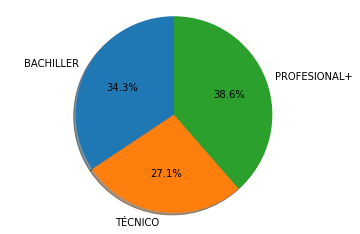

In [12]:
# Gráfica grupos de nivel educativo
labels = list(GRUPOS_EDUCATIVOS.keys())
sizes = []
for grupo in GRUPOS_EDUCATIVOS:
    sizes.append(len(datos[datos[COLUMNAS_ADICIONALES['nivelE']] == grupo]))
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [13]:
len(datosRenombrados)

4854

In [14]:
datosRenombrados

,DOCUMENTO,CODIGO,NOMBRE,APELLIDO,TELEFONO,EMAIL,DEDICACION RUTA,DISP_PROGRAMACION,DISP_INGLES,DISP_COACHING,...,OCUPACION,TITULO_SI_TIENE,DISCAPACIDAD,DETALLE_DISCAPACIDAD,PAIS_NACIMIENTO,CIUDAD_NACIMIENTO,PAIS_DE_RECIDENCIA,CIUDAD_DE_RECIDENCIA,NIVEL_EDUCATIVO_AGRUPADO,OBSERVACION
0,1013605766,2220001.0,Steven,Lizarazo Peña,3006408216,stevenlipe@gmail.com,2 horas,Jornada de la noche (8 p.m. a 10 p.m.);Jornada...,Jornada de la noche (7 p.m. a 8 p.m.);Jornada ...,Jornada de la noche (7 p.m. a 8 p.m.);Jornada ...,...,EMPLEADO / OBRERO DEL SECTOR PRIVADO,BIÓLOGO,No,NaN,Colombia,Bogotá,Colombia,Bogotá,PROFESIONAL+,
1,1010203197,2220002.0,Sara Viviana,Carrero Puentes,3044733148,svcarrerop@unal.edu.co,4 horas,Jornada de la noche (6 p.m. a 8 p.m.);Jornada ...,Jornada de la noche (7 p.m. a 8 p.m.);Jornada ...,Jornada de la noche (7 p.m. a 8 p.m.);Jornada ...,...,EMPLEADO / OBRERO DEL SECTOR PRIVADO,ZOOTECNISTA,No,NaN,Colombia,Bogotá,Colombia,Bogotá,PROFESIONAL+,
2,1000493253,2220003.0,Andres Felipe,Diaz Barrios,3022163198,lv72570@gmail.com,4 horas,Jornada de la noche (8 p.m. a 10 p.m.),Jornada de la noche (6 p.m. a 7 p.m.),Jornada de la noche (7 p.m. a 8 p.m.),...,ESTUDIANTE,TECNICO EN MECANIZADO DE PRODUCTOS METALMECANICOS,No,NaN,Colombia,Bogota,Colombia,Bogota,BACHILLER,
3,1005340078,2220004.0,CARLOS JOSSEPH,RODRIGUEZ HERNANDEZ,3227001834,jossephrguezz@gmail.com,4 horas,Jornada de la tarde (4 p.m. a 6 p.m.);Jornada ...,Jornada de la noche (9 p.m. a 10 p.m.),Jornada de la noche (9 p.m. a 10 p.m.),...,ESTUDIANTE,ACTUAL ESTUDIANTE DE LA UIS,No,NaN,COLOMBIA,BUCARAMANGA,COLOMBIA,PIEDECUESTA,PROFESIONAL+,
4,10292579,2220005.0,FABIO NELSON,SARRIA SOLARTE,3127023890,SANEL1029@YAHOO.COM,4 horas,Jornada de la noche (6 p.m. a 8 p.m.);Jornada ...,Jornada de la noche (8 p.m. a 9 p.m.);Jornada ...,Jornada de la noche (6 p.m. a 7 p.m.);Jornada ...,...,EMPLEADO / OBRERO DEL SECTOR PÚBLICO,ADMINISTARDOR FINANCIERO,No,NaN,COLOMBIA,TIMBIO,COLOMBIA,POPAYÁN,PROFESIONAL+,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,1065821902,2224290.0,JUAN FELIPE,GALLEGO DIAZ,3158932278,JUANFEGALLEGOD@GMAIL.COM,4 horas,Jornada de la noche (6 p.m. a 8 p.m.);Jornada ...,Jornada de la noche (8 p.m. a 9 p.m.);Jornada ...,Jornada de la noche (6 p.m. a 7 p.m.);Jornada ...,...,ESTUDIANTE,NaN,No,NaN,COLOMBIA,BOGOTA,COLOMBIA,VALLEDUPAR,TÉCNICO,
4850,1031171943,2224291.0,SANTIAGO,DUQUE SANCHEZ,3133348179,santidukesan@gmail.com,6 horas,Jornada de la noche (6 p.m. a 8 p.m.);Jornada ...,Jornada de la mañana (6 a.m. a 7 a.m.);Jornada...,Jornada de la mañana (6 a.m. a 7 a.m.);Jornada...,...,EMPLEADO / OBRERO DEL SECTOR PRIVADO,TECNOLOGO EN TOPOGRAFÍA,No,NaN,Colombia,Bogotá,Colombia,Bogotá,PROFESIONAL+,
4851,38603088,2224292.0,VIVIANA ANDREA,CARVAJAL GOMEZ,3137406203,andreita82261@gmail.com,4 horas,Jornada de la noche (8 p.m. a 10 p.m.),Jornada de la noche (7 p.m. a 8 p.m.),Jornada de la noche (6 p.m. a 7 p.m.);Jornada ...,...,ESTUDIANTE,ADMINISTRADOR DE NEGOCIOS,No,NaN,Colombia,Cali,Colombia,Cali,PROFESIONAL+,
4852,1118291370,2224293.0,JOSE ANTONIO,SAMBONI CARVAJAL,3148883169,hjsambo@gmail.com,4 horas,Jornada de la noche (8 p.m. a 10 p.m.),Jornada de la noche (7 p.m. a 8 p.m.),Jornada de la noche (6 p.m. a 7 p.m.),...,EMPLEADO / OBRERO DEL SECTOR PRIVADO,INGENIERO DE SISTEMAS,No,NaN,Colombia,Cali,Colombia,Cali,PROFESIONAL+,
